In [120]:
import numpy as np
from SimPEG.electromagnetics import natural_source as nsem
from SimPEG import maps
import matplotlib.pyplot as plt
import matplotlib
from SimPEG.utils import plot_1d_layer_model
from discretize import TensorMesh
from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
matplotlib.rcParams['font.size'] = 14

In [121]:
frequencies = np.logspace(-3, 2, 31)

In [122]:
layer_thicknesses = np.array([1000, 1000])
rho = np.array([1000., 10, 1000.])

mesh = TensorMesh([(np.r_[layer_thicknesses, layer_thicknesses[-1]])], "0")

wire_map = maps.Wires(("sigma", mesh.nC), ("t", mesh.nC - 1))
sigma_map = maps.ExpMap(nP=mesh.nC) * wire_map.sigma
layer_map = maps.ExpMap(nP=mesh.nC - 1) * wire_map.t


model_mapping = maps.IdentityMap(nP=len(rho))

receivers_list = [
    nsem.receivers.PointNaturalSource(component="app_res"),
    nsem.receivers.PointNaturalSource(component="phase"),
]


source_list = []
for freq in frequencies:
    source_list.append(nsem.sources.Planewave(receivers_list, freq))

survey = nsem.survey.Survey(source_list)

simulation = nsem.simulation_1d.Simulation1DRecursive(
    survey=survey, 
    sigmaMap=sigma_map,
    thicknessesMap=layer_map,
)

true_model = np.r_[np.log(1./rho), np.log(layer_thicknesses)]

dpred = simulation.dpred(true_model)

Text(0.5, 0, 'Frequency (Hz)')

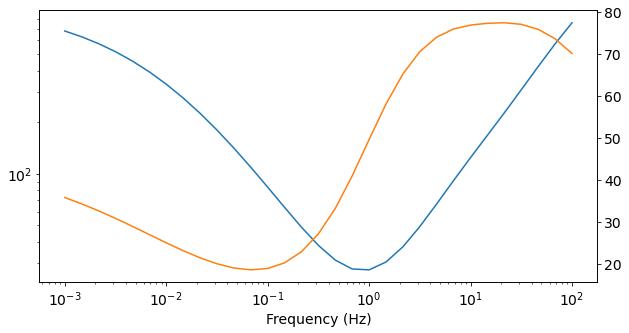

In [123]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
ax.loglog(frequencies, dpred.reshape((len(frequencies), 2))[:,0], color='C0')
ax_1 = ax.twinx()
ax_1.plot(frequencies, dpred.reshape((len(frequencies), 2))[:,1], color='C1')
ax.set_xlabel("Frequency (Hz)")

In [124]:
amp = dpred.reshape((len(frequencies), 2))[:,0]
phase = dpred.reshape((len(frequencies), 2))[:,1]

In [125]:
std = np.c_[abs(amp)*0.03, np.ones(len(phase))*5].flatten()
data_object = data.Data(survey, dobs=dpred, standard_deviation=std)

In [126]:
starting_model = np.log(np.r_[np.ones(3)*1./2000, np.ones(2)*3000])

In [127]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

# Define the regularization on the parameters related to resistivity
mesh_sigma = TensorMesh([mesh.hx.size])
reg_sigma = regularization.Simple(mesh_sigma, alpha_s=0.01, alpha_x=0, mapping=wire_map.sigma)

# Define the regularization on the parameters related to layer thickness
mesh_t = TensorMesh([mesh.hx.size - 1])
reg_t = regularization.Simple(mesh_t, alpha_s=0.01, alpha_x=0, mapping=wire_map.t)

# Combine to make regularization for the inversion problem
reg = reg_sigma + reg_t

# Define how the optimization problem is solved. Here we will use an inexact
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.InexactGaussNewton(maxIter=30, maxIterCG=50)

# Define the inverse problem
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

#######################################################################
# Define Inversion Directives
# ---------------------------
#
# Here we define any directives that are carried out during the inversion. This
# includes the cooling schedule for the trade-off parameter (beta), stopping
# criteria for the inversion and saving inversion results at each iteration.
#

# Apply and update sensitivity weighting as the model updates
update_sensitivity_weights = directives.UpdateSensitivityWeights()

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e0)

# Set the rate of reduction in trade-off parameter (beta) each time the
# the inverse problem is solved. And set the number of Gauss-Newton iterations
# for each trade-off paramter value.
beta_schedule = directives.BetaSchedule(coolingFactor=5.0, coolingRate=3)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

# The directives are defined in a list
directives_list = [
    update_sensitivity_weights,
    starting_beta,
    beta_schedule,
    target_misfit,
]

#####################################################################
# Running the Inversion
# ---------------------
#
# To define the inversion object, we need to define the inversion problem and
# the set of directives. We can then run the inversion.
#

# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directiveList=directives_list)

# Run the inversion
recovered_model = inv.run(starting_model)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.27e+09  1.71e+07  0.00e+00  1.71e+07    2.18e+07      0              
   1  4.27e+09  5.48e+06  1.20e-03  1.06e+07    4.36e+06      0              
   2  4.27e+09  7.56e+06  5.82e-04  1.00e+07    1.88e+06      0              
   3  8.53e+08  6.56e+06  9.38e-04  7.36e+06    6.07e+06      0              
   4  8.53e+08  2.32e+06  2.66e-03  4.59e+06    5.66e+05      0              
   5  8.53e+08  2.08e+06  3.01e-03  4.66e+06    1.64e+05      0              
   6

Text(0.5, 0, 'Frequency (Hz)')

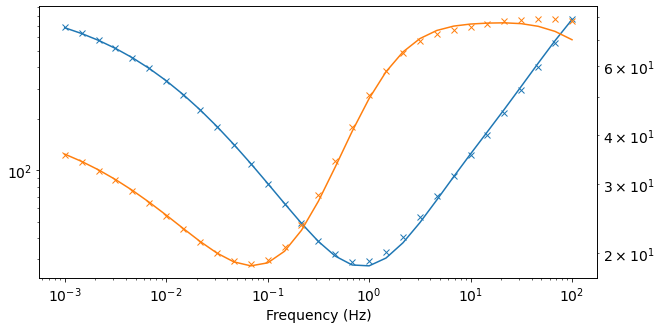

In [128]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
ax.loglog(frequencies, dpred.reshape((len(frequencies), 2))[:,0], color='C0')
ax.loglog(frequencies, inv_prob.dpred.reshape((len(frequencies), 2))[:,0], 'x', color='C0')
ax_1 = ax.twinx()
ax_1.plot(frequencies, dpred.reshape((len(frequencies), 2))[:,1], color='C1')
ax_1.loglog(frequencies, inv_prob.dpred.reshape((len(frequencies), 2))[:,1], 'x', color='C1')
ax.set_xlabel("Frequency (Hz)")

(0.0001, 1)

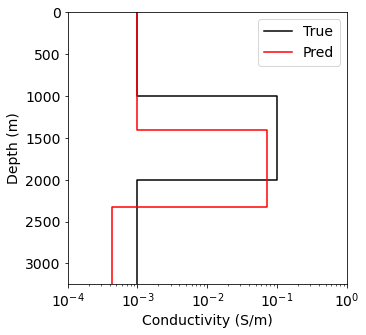

In [129]:
# Plot true model and recovered model
fig, ax = plt.subplots(1,1,figsize=(5, 5))

x_min = np.min([np.min(sigma_map * recovered_model), np.min(true_model)])
x_max = np.max([np.max(sigma_map * recovered_model), np.max(true_model)])

# ax1 = fig.add_axes([0.2, 0.15, 0.7, 0.7])
plot_1d_layer_model(layer_thicknesses, 1./rho, ax=ax, color="k", **{'label':'True'})
plot_1d_layer_model(
    layer_map * recovered_model,
    sigma_map * recovered_model,
    ax=ax,
    color="r",**{'label':'Pred'}
)
ax.legend()
ax.set_xlabel("Conductivity (S/m)")
ax.set_xlim(1e-4, 1)